In [2]:
import torch
torch.cuda.is_available()

True

In [5]:
ethanol_atoms = torch.tensor([6, 6, 1, 1, 1, 1, 1, 8])
ethanol_atoms.dtype, ethanol_atoms.device

(torch.int64, device(type='cpu'))

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# Это не будет работать
ethanol_atoms = torch.tensor([6, 6, 1, 1, 1, 1, 1, 8]).to(device)
charge = torch.tensor([-1, 0, 0, 0, 0, 0, 0, 0])
ethanol_atoms+charge

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [13]:
print(ethanol_atoms)

tensor([6, 6, 1, 1, 1, 1, 1, 8], device='cuda:0')


In [14]:
import matplotlib.pylab as plt

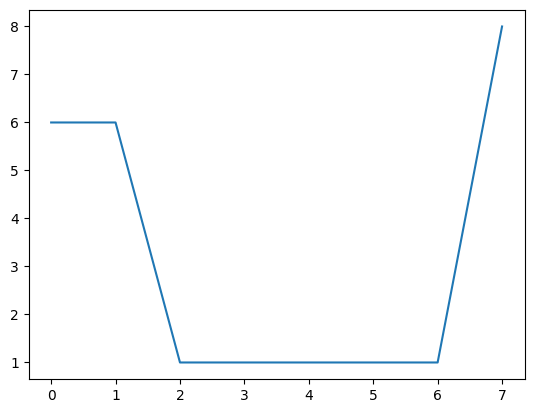

In [16]:
plt.plot(ethanol_atoms.detach().cpu().numpy())

In [17]:
ethanol_atoms**2

tensor([36, 36,  1,  1,  1,  1,  1, 64], device='cuda:0')

In [20]:
ethanol_atoms.sum()

tensor(25, device='cuda:0')

# Gradient example with Lennard-Jonnes function

In [38]:
epsilon = 0.103  # eV
sigma = 3.4     # Å

def lennard_jones(r):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

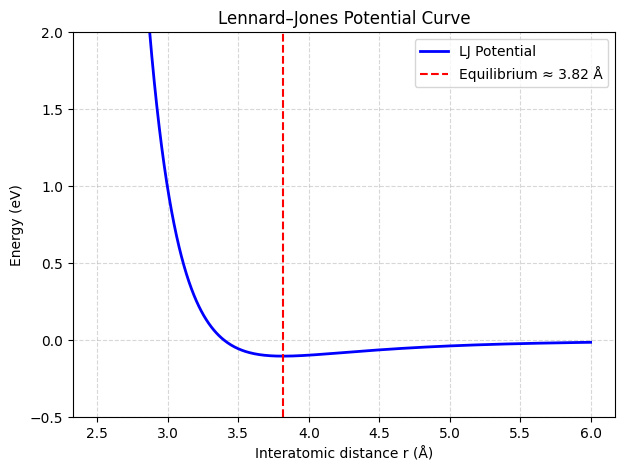

In [57]:
r_values = torch.linspace(2.5, 6.0, 400)
E_values = lennard_jones(r_values)

# equilibrium distance
r_eq = (2)**(1/6) * sigma

plt.figure(figsize=(7,5))
plt.plot(r_values, E_values, color='blue', lw=2, label="LJ Potential")
plt.axvline(r_eq, color='r', linestyle='--', label=f"Equilibrium ≈ {r_eq:.2f} Å")
plt.title("Lennard–Jones Potential Curve")
plt.xlabel("Interatomic distance r (Å)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.ylim([-0.5,2])
plt.grid(True, ls='--', alpha=0.5)
plt.show()

In [58]:
r = torch.tensor(2.5, device=device)
E = lennard_jones(r)
E

tensor(13.8885, device='cuda:0')

In [59]:
r = torch.tensor(3.0, requires_grad=True, device=device)
E = lennard_jones(r)
E.backward()   # computes dE/dr and stores it in r.grad
E, r.grad.item()

(tensor(0.9770, device='cuda:0', grad_fn=<MulBackward0>), -5.654189109802246)

In [60]:
r = torch.tensor(5.0, requires_grad=True, device=device)
E = lennard_jones(r)
E.backward()   # computes dE/dr and stores it in r.grad
E, r.grad.item() 

(tensor(-0.0367, device='cuda:0', grad_fn=<MulBackward0>),
 0.039214786142110825)

In [72]:
# Initialization
r = torch.tensor(5.0, requires_grad=True, device=device)
lr = 0.5  # learning rate
steps = 50

# To store the trajectory
r_values, E_values = [], []

for step in range(steps):
    E = lennard_jones(r)
    E.backward()           # compute dE/dr

    # gradient descent step
    with torch.no_grad():
        r -= lr * r.grad   # update r manually
    r.grad.zero_()         # clear gradient

    # store trajectory
    r_values.append(r.item())
    E_values.append(E.item())

    if step % 5 == 0:
        print(f"Step {step:02d}: r = {r.item():.4f} Å | E = {E.item():.6f} eV")


Step 00: r = 4.9804 Å | E = -0.036706 eV
Step 05: r = 4.8756 Å | E = -0.040960 eV
Step 10: r = 4.7577 Å | E = -0.046327 eV
Step 15: r = 4.6240 Å | E = -0.053218 eV
Step 20: r = 4.4718 Å | E = -0.062146 eV
Step 25: r = 4.3009 Å | E = -0.073481 eV
Step 30: r = 4.1207 Å | E = -0.086458 eV
Step 35: r = 3.9620 Å | E = -0.097361 eV
Step 40: r = 3.8658 Å | E = -0.102101 eV
Step 45: r = 3.8294 Å | E = -0.102927 eV


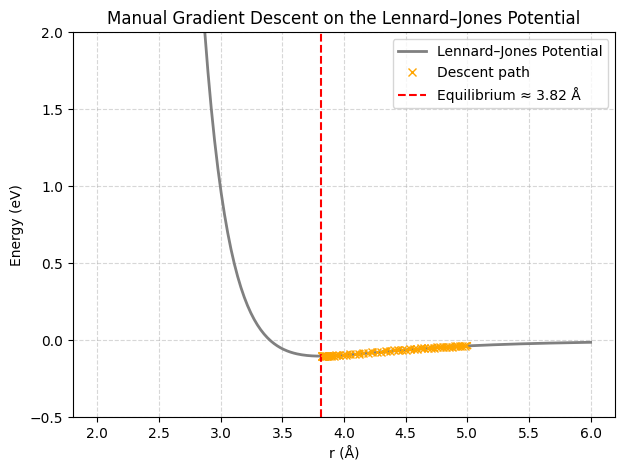

In [73]:
# Prepare the curve
r_plot = torch.linspace(2.0, 6.0, 300)
E_plot = lennard_jones(r_plot)

plt.figure(figsize=(7,5))
plt.plot(r_plot.cpu(), E_plot.cpu(), color='gray', lw=2, label='Lennard–Jones Potential')
plt.plot(r_values, E_values, 'x', color='orange', label='Descent path')
plt.axvline(r_eq, color='r', linestyle='--', label=f'Equilibrium ≈ {r_eq:.2f} Å')

# draw arrows for steps
for i in range(1, len(r_values), 3):
    plt.annotate('', xy=(r_values[i], E_values[i]), xytext=(r_values[i-1], E_values[i-1]),
                 arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))

plt.title("Manual Gradient Descent on the Lennard–Jones Potential")
plt.xlabel("r (Å)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.ylim([-0.5,2])
plt.grid(True, ls='--', alpha=0.5)
plt.show()


# Что происходит про очень большом LR

Step 00: r = 4.8039 Å | E = -0.036706 eV
Step 05: r = 3.9985 Å | E = -0.100974 eV
Step 10: r = 3.7124 Å | E = -0.097218 eV
Step 15: r = 4.0684 Å | E = -0.099615 eV
Step 20: r = 3.7391 Å | E = -0.092473 eV
Step 25: r = 3.9824 Å | E = -0.101256 eV
Step 30: r = 3.7114 Å | E = -0.097779 eV
Step 35: r = 4.0701 Å | E = -0.099580 eV
Step 40: r = 3.7395 Å | E = -0.092428 eV
Step 45: r = 3.9820 Å | E = -0.101263 eV


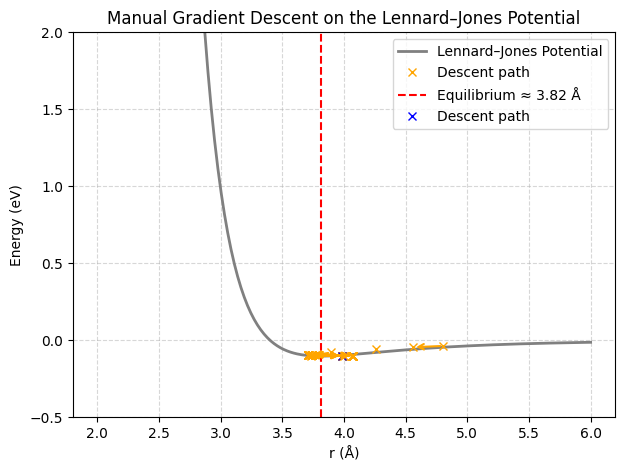

In [82]:


# Initialization
r = torch.tensor(5.0, requires_grad=True, device=device)
lr = 5  # learning rate
steps = 50

# To store the trajectory
r_values, E_values = [], []

for step in range(steps):
    E = lennard_jones(r)
    E.backward()           # compute dE/dr

    # gradient descent step
    with torch.no_grad():
        r -= lr * r.grad   # update r manually
    r.grad.zero_()         # clear gradient

    # store trajectory
    r_values.append(r.item())
    E_values.append(E.item())

    if step % 5 == 0:
        print(f"Step {step:02d}: r = {r.item():.4f} Å | E = {E.item():.6f} eV")

# Prepare the curve
r_plot = torch.linspace(2.0, 6.0, 300)
E_plot = lennard_jones(r_plot)

plt.figure(figsize=(7,5))
plt.plot(r_plot.cpu(), E_plot.cpu(), color='gray', lw=2, label='Lennard–Jones Potential')
plt.plot(r_values, E_values, 'x', color='orange', label='Descent path')
plt.axvline(r_eq, color='r', linestyle='--', label=f'Equilibrium ≈ {r_eq:.2f} Å')
plt.plot([r_values[-1]], [E_values[-1]], 'x', color='blue', label='Descent path')

# draw arrows for steps
for i in range(1, len(r_values), 3):
    plt.annotate('', xy=(r_values[i], E_values[i]), xytext=(r_values[i-1], E_values[i-1]),
                 arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))

plt.title("Manual Gradient Descent on the Lennard–Jones Potential")
plt.xlabel("r (Å)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.ylim([-0.5,2])
plt.grid(True, ls='--', alpha=0.5)
plt.show()


# Что происходит про очень маленьком RL

Step 00: r = 5.0000 Å | E = -0.036706 eV
Step 05: r = 4.9999 Å | E = -0.036710 eV
Step 10: r = 4.9998 Å | E = -0.036714 eV
Step 15: r = 4.9997 Å | E = -0.036718 eV
Step 20: r = 4.9996 Å | E = -0.036722 eV
Step 25: r = 4.9995 Å | E = -0.036725 eV
Step 30: r = 4.9994 Å | E = -0.036729 eV
Step 35: r = 4.9993 Å | E = -0.036733 eV
Step 40: r = 4.9992 Å | E = -0.036737 eV
Step 45: r = 4.9991 Å | E = -0.036741 eV


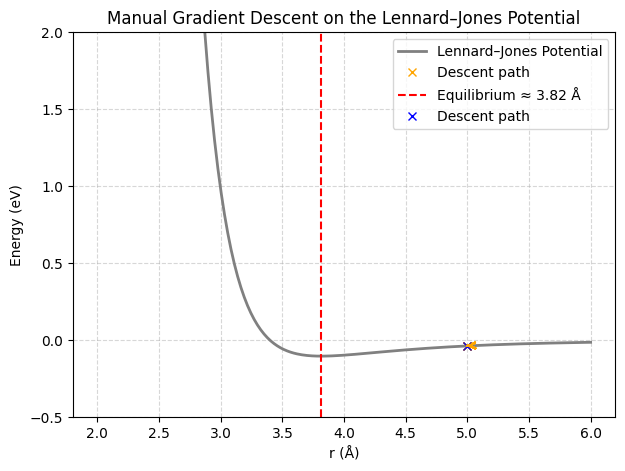

In [85]:
# Initialization
r = torch.tensor(5.0, requires_grad=True, device=device)
lr = 0.0005  # learning rate
steps = 50

# To store the trajectory
r_values, E_values = [], []

for step in range(steps):
    E = lennard_jones(r)
    E.backward()           # compute dE/dr

    # gradient descent step
    with torch.no_grad():
        r -= lr * r.grad   # update r manually
    r.grad.zero_()         # clear gradient

    # store trajectory
    r_values.append(r.item())
    E_values.append(E.item())

    if step % 5 == 0:
        print(f"Step {step:02d}: r = {r.item():.4f} Å | E = {E.item():.6f} eV")

# Prepare the curve
r_plot = torch.linspace(2.0, 6.0, 300)
E_plot = lennard_jones(r_plot)

plt.figure(figsize=(7,5))
plt.plot(r_plot.cpu(), E_plot.cpu(), color='gray', lw=2, label='Lennard–Jones Potential')
plt.plot(r_values, E_values, 'x', color='orange', label='Descent path')
plt.axvline(r_eq, color='r', linestyle='--', label=f'Equilibrium ≈ {r_eq:.2f} Å')
plt.plot([r_values[-1]], [E_values[-1]], 'x', color='blue', label='Descent path')

# draw arrows for steps
for i in range(1, len(r_values), 3):
    plt.annotate('', xy=(r_values[i], E_values[i]), xytext=(r_values[i-1], E_values[i-1]),
                 arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))

plt.title("Manual Gradient Descent on the Lennard–Jones Potential")
plt.xlabel("r (Å)")
plt.ylabel("Energy (eV)")
plt.legend()
plt.ylim([-0.5,2])
plt.grid(True, ls='--', alpha=0.5)
plt.show()


# Ключевые элементы обучения модели

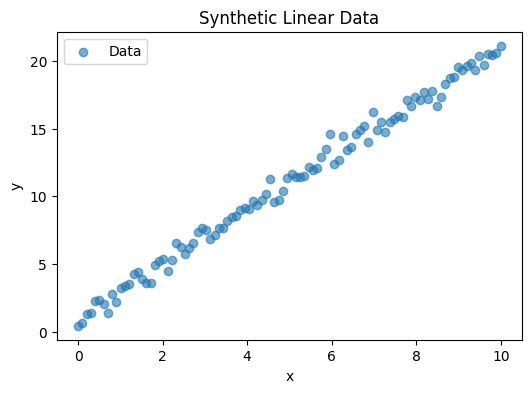

In [94]:
import torch
import matplotlib.pyplot as plt

# Create synthetic data: y = 2x + 1 + noise
torch.manual_seed(0)
X = torch.linspace(0, 10, 100).unsqueeze(1)  # shape (100, 1)
y = 2 * X + 1 + 0.5 * torch.randn_like(X)

plt.figure(figsize=(6,4))
plt.scatter(X, y, label="Data", alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic Linear Data")
plt.legend()
plt.show()


In [95]:
# Random initialization
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

print(f"Initial w = {w.item():.3f}, b = {b.item():.3f}")


Initial w = 1.323, b = 0.037


In [96]:
def predict(X):
    return X * w + b

def mse_loss(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()


In [97]:
learning_rate = 0.01
steps = 200

w_values, b_values, loss_values = [], [], []

for step in range(steps):
    y_pred = predict(X)
    loss = mse_loss(y_pred, y)

    loss.backward()  # compute gradients

    # Manual parameter update (no torch.optim)
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Zero gradients before next iteration
    w.grad.zero_()
    b.grad.zero_()

    # Track for visualization
    w_values.append(w.item())
    b_values.append(b.item())
    loss_values.append(loss.item())

    if step % 20 == 0:
        print(f"Step {step:3d}: loss = {loss.item():.6f}, w = {w.item():.3f}, b = {b.item():.3f}")


Step   0: loss = 23.212221, w = 1.875, b = 0.124
Step  20: loss = 0.416533, w = 2.116, b = 0.244
Step  40: loss = 0.388707, w = 2.105, b = 0.317
Step  60: loss = 0.365904, w = 2.095, b = 0.384
Step  80: loss = 0.347217, w = 2.086, b = 0.444
Step 100: loss = 0.331902, w = 2.078, b = 0.498
Step 120: loss = 0.319352, w = 2.071, b = 0.548
Step 140: loss = 0.309067, w = 2.064, b = 0.592
Step 160: loss = 0.300638, w = 2.058, b = 0.633
Step 180: loss = 0.293731, w = 2.052, b = 0.669


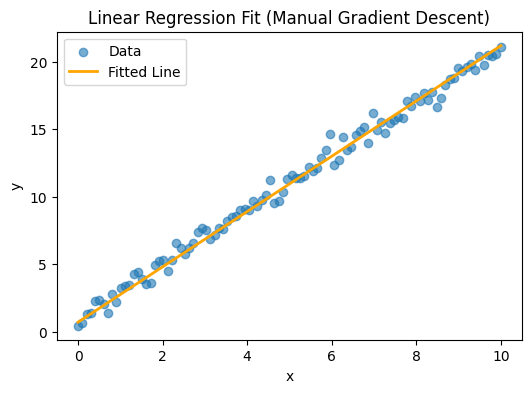

In [98]:
plt.figure(figsize=(6,4))
plt.scatter(X, y, label="Data", alpha=0.6)
plt.plot(X, predict(X).detach(), color="orange", label="Fitted Line", lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression Fit (Manual Gradient Descent)")
plt.legend()
plt.show()


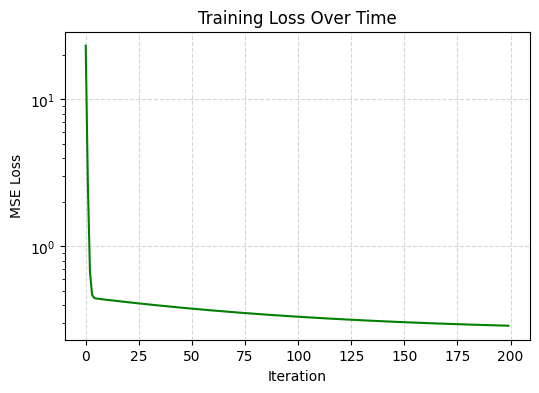

In [99]:
plt.figure(figsize=(6,4))
plt.plot(loss_values, color="green")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.title("Training Loss Over Time")
plt.grid(True, ls="--", alpha=0.5)
plt.show()


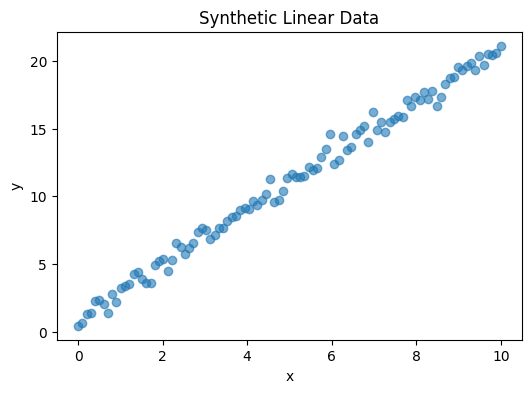

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Synthetic dataset: y = 2x + 1 + noise
torch.manual_seed(0)
X = torch.linspace(0, 10, 100).unsqueeze(1)  # shape (100, 1)
y = 2 * X + 1 + 0.5 * torch.randn_like(X)

plt.figure(figsize=(6,4))
plt.scatter(X, y, alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic Linear Data")
plt.show()


In [101]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # 1 input → 1 output

    def forward(self, x):
        return self.linear(x)


In [102]:
model = LinearRegressionModel()
print(model)


LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [103]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [104]:
epochs = 200
loss_values = []

for epoch in range(epochs):
    # Forward pass
    y_pred = model(X)
    loss = loss_fn(y_pred, y)

    # Backward pass
    optimizer.zero_grad()   # clear old gradients
    loss.backward()         # compute new gradients
    optimizer.step()        # update parameters

    loss_values.append(loss.item())

    if epoch % 20 == 0:
        [w, b] = model.linear.parameters()
        print(f"Epoch {epoch:3d} | loss = {loss.item():.6f} | w = {w.item():.3f} | b = {b.item():.3f}")


Epoch   0 | loss = 192.530701 | w = 1.355 | b = 0.289
Epoch  20 | loss = 0.342823 | w = 2.084 | b = 0.459
Epoch  40 | loss = 0.328302 | w = 2.076 | b = 0.512
Epoch  60 | loss = 0.316401 | w = 2.069 | b = 0.560
Epoch  80 | loss = 0.306649 | w = 2.062 | b = 0.604
Epoch 100 | loss = 0.298656 | w = 2.056 | b = 0.643
Epoch 120 | loss = 0.292107 | w = 2.051 | b = 0.679
Epoch 140 | loss = 0.286739 | w = 2.046 | b = 0.711
Epoch 160 | loss = 0.282341 | w = 2.042 | b = 0.740
Epoch 180 | loss = 0.278736 | w = 2.038 | b = 0.767


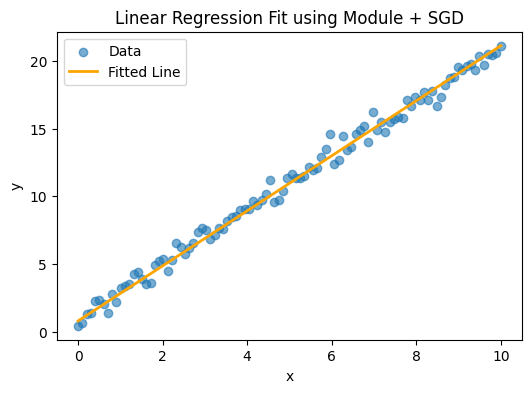

In [105]:
plt.figure(figsize=(6,4))
plt.scatter(X, y, label="Data", alpha=0.6)
plt.plot(X, model(X).detach(), color="orange", lw=2, label="Fitted Line")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression Fit using Module + SGD")
plt.legend()
plt.show()


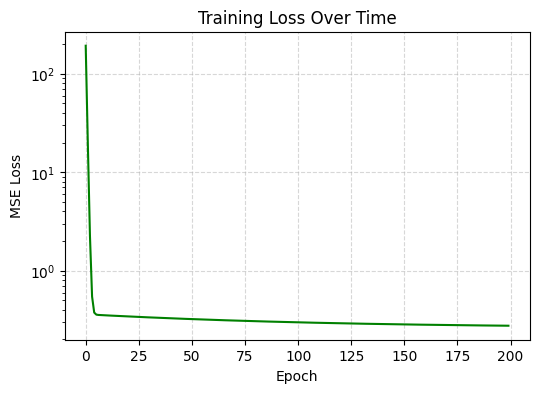

In [108]:
plt.figure(figsize=(6,4))
plt.plot(loss_values, color="green")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Time")
plt.yscale('log')
plt.grid(True, ls="--", alpha=0.5)
plt.show()
